In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
import joblib

try:
    import xgboost as xgb
    xgboost_available = True
except Exception:
    xgboost_available = False

print('Libraries imported. xgboost available:', xgboost_available)

Libraries imported. xgboost available: True


### Data Loading


In [2]:
csv_path = 'vgsales.csv'

if not os.path.exists(csv_path):
    print(f"File '{csv_path}' not found in current directory: {os.getcwd()}")
    print("Please place 'vgsales.csv' here or update the path.")
else:
    df = pd.read_csv(csv_path)
    print('Dataset loaded. Shape:', df.shape)
    display(df.head())

Dataset loaded. Shape: (16598, 11)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## 2) Exploratory Data Analysis (EDA)


In [3]:
try:
    display(df.info())
    display(df.describe(include='all').T)
    print('\nMissing values per column:')
    display(df.isnull().sum())
except NameError:
    print('Dataset not loaded. Run the previous cell to load vgsales.csv.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Rank,16598.0,NaN,NaN,NaN,8300.605254,4791.853933,1.0,4151.25,8300.5,12449.75,16600.0
Name,16598,11493,Need for Speed: Most Wanted,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform,16598,31,DS,2163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,16327.0,NaN,NaN,NaN,2006.406443,5.828981,1980.0,2003.0,2007.0,2010.0,2020.0
Genre,16598,12,Action,3316,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Publisher,16540,578,Electronic Arts,1351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_Sales,16598.0,NaN,NaN,NaN,0.264667,0.816683,0.0,0.0,0.08,0.24,41.49
EU_Sales,16598.0,NaN,NaN,NaN,0.146652,0.505351,0.0,0.0,0.02,0.11,29.02
JP_Sales,16598.0,NaN,NaN,NaN,0.077782,0.309291,0.0,0.0,0.0,0.04,10.22
Other_Sales,16598.0,NaN,NaN,NaN,0.048063,0.188588,0.0,0.0,0.01,0.04,10.57



Missing values per column:


,0
Rank,0
Name,0
Platform,0
Year,271
Genre,0
Publisher,58
NA_Sales,0
EU_Sales,0
JP_Sales,0
Other_Sales,0


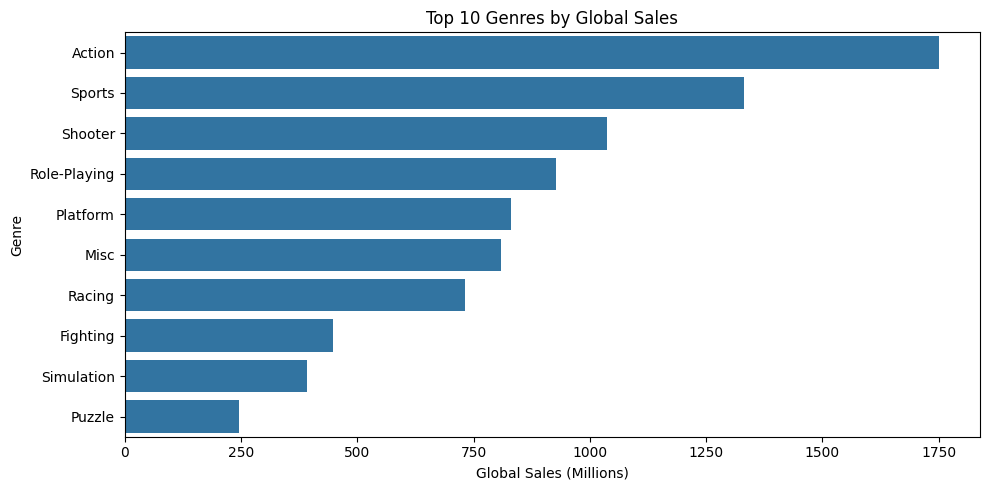

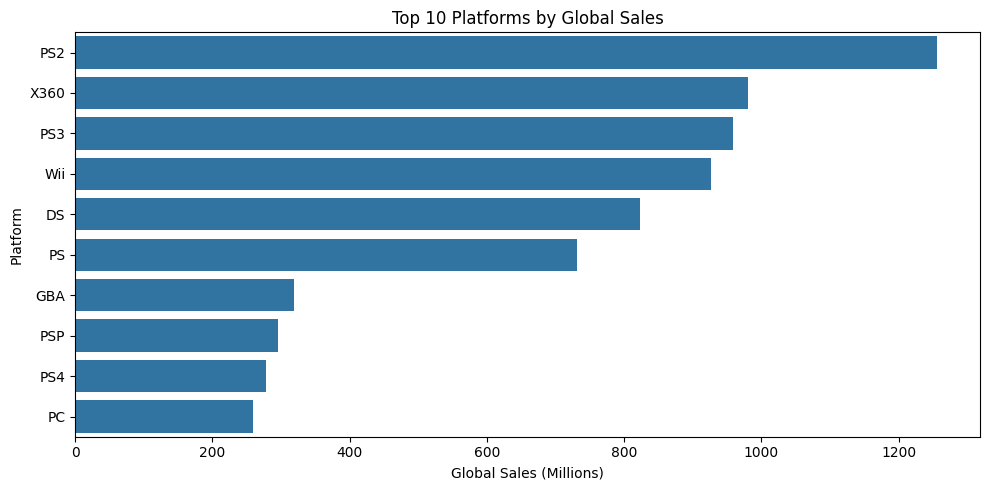

In [4]:
try:
    plt.figure(figsize=(10,5))
    top_genres = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(10)
    sns.barplot(x=top_genres.values, y=top_genres.index)
    plt.title('Top 10 Genres by Global Sales')
    plt.xlabel('Global Sales (Millions)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    top_platforms = df.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head(10)
    sns.barplot(x=top_platforms.values, y=top_platforms.index)
    plt.title('Top 10 Platforms by Global Sales')
    plt.xlabel('Global Sales (Millions)')
    plt.tight_layout()
    plt.show()
except NameError:
    print('Dataset not loaded. Run the load cell first.')

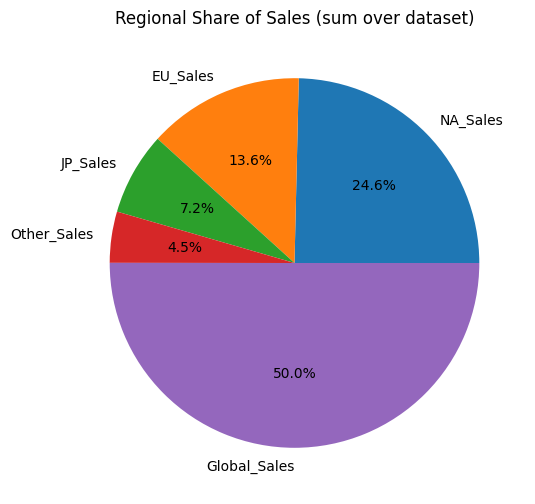

In [5]:
try:
    sales_cols = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']
    existing = [c for c in sales_cols if c in df.columns]
    df[existing].sum().plot.pie(autopct='%1.1f%%', figsize=(6,6))
    plt.title('Regional Share of Sales (sum over dataset)')
    plt.ylabel('')
    plt.show()
except NameError:
    print('Dataset not loaded. Run the load cell first.')

### Correlation between scores and sales

In [6]:
try:
    score_cols = [c for c in ['Critic_Score','User_Score','User_Count','Global_Sales'] if c in df.columns]
    if len(score_cols) >= 2:
        plt.figure(figsize=(8,6))
        sns.heatmap(df[score_cols].corr(), annot=True, fmt='.2f')
        plt.title('Correlation matrix (scores vs sales)')
        plt.show()
    else:
        print('Score or sales columns not found in dataset.')
except NameError:
    print('Dataset not loaded. Run the load cell first.')

Score or sales columns not found in dataset.


## 3) Feature Engineering


In [7]:
try:
    data = df.copy()

    for year_col in ['Year','Year_of_Release','ReleaseYear']:
        if year_col in data.columns:
            data['Year'] = pd.to_numeric(data[year_col], errors='coerce')
            break

    num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    data[num_cols] = data[num_cols].fillna(data[num_cols].median())

    cat_cols = data.select_dtypes(include=['object']).columns.tolist()
    data[cat_cols] = data[cat_cols].fillna('Unknown')


    if 'User_Score' in data.columns and 'Critic_Score' in data.columns:

        data['User_Score'] = pd.to_numeric(data['User_Score'], errors='coerce')
        data['Critic_Score'] = pd.to_numeric(data['Critic_Score'], errors='coerce')

        data['Critic_Score_scaled'] = data['Critic_Score'] / 10.0
        data['Engagement_Score'] = data[['User_Score','Critic_Score_scaled']].mean(axis=1)
        data['Engagement_Score'] = data['Engagement_Score'].fillna(data['Engagement_Score'].median())


    le = LabelEncoder()
    for col in ['Platform','Genre','Publisher','Developer','Rating']:
        if col in data.columns:
            data[col+'_enc'] = le.fit_transform(data[col].astype(str))

    display(data.head())
except NameError:
    print('Dataset not loaded. Run the load cell first.')

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform_enc,Genre_enc,Publisher_enc
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,26,10,359
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,11,4,359
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,26,6,359
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,26,10,359
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,5,7,359


## 4) Model Building — Predict Global Sales


Linear Regression R2: 0.9999934714729736 MSE: 2.7428718268290425e-05
Random Forest R2: 0.8208474542333268 MSE: 0.7526850520730453


,0
NA_Sales,0.848145
EU_Sales,0.103704
JP_Sales,0.031488
Other_Sales,0.012384
Year,0.001322
Platform_enc,0.001321
Genre_enc,0.001120
Publisher_enc,0.000517


Model saved to rf_videogame_sales_model.joblib


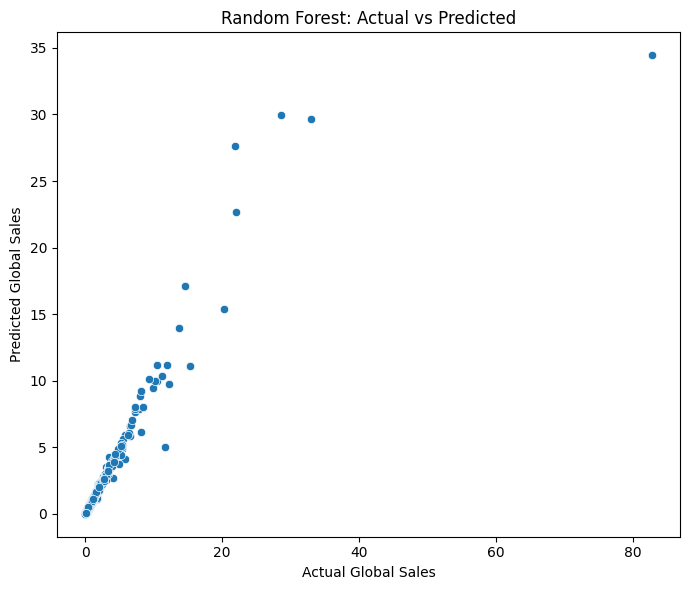

In [8]:
try:

    target = 'Global_Sales'
    if target not in data.columns:
        raise ValueError(f"Target column '{target}' not found.")


    feature_candidates = []
    for c in ['Year','NA_Sales','EU_Sales','JP_Sales','Other_Sales','User_Score','Critic_Score','User_Count']:
        if c in data.columns:
            feature_candidates.append(c)

    for c in ['Platform_enc','Genre_enc','Publisher_enc','Rating_enc','Developer_enc','Engagement_Score']:
        if c in data.columns:
            feature_candidates.append(c)

    X = data[feature_candidates].fillna(0)
    y = data[target].fillna(0)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print('Linear Regression R2:', r2_score(y_test, y_pred_lr), 'MSE:', mean_squared_error(y_test, y_pred_lr))

    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print('Random Forest R2:', r2_score(y_test, y_pred_rf), 'MSE:', mean_squared_error(y_test, y_pred_rf))

    try:
        importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
        display(importances.head(15))
    except Exception as e:
        print('Could not compute feature importances:', e)

    model_path = 'rf_videogame_sales_model.joblib'
    joblib.dump(rf, model_path)
    print(f'Model saved to {model_path}')


    plt.figure(figsize=(7,6))
    sns.scatterplot(x=y_test, y=y_pred_rf)
    plt.xlabel('Actual Global Sales')
    plt.ylabel('Predicted Global Sales')
    plt.title('Random Forest: Actual vs Predicted')
    plt.tight_layout()
    plt.show()

except NameError:
    print('Feature engineering not run. Execute previous cells.')

## 5) Engagement Analysis & Clustering


In [9]:
try:
    cluster_cols = []
    if 'Engagement_Score' in data.columns:
        cluster_cols.append('Engagement_Score')
    if 'User_Count' in data.columns:
        cluster_cols.append('User_Count')
    if not cluster_cols:
        print('No engagement-related columns found for clustering.')
    else:
        cluster_data = data[cluster_cols].fillna(0)
        scaler = StandardScaler()
        cluster_scaled = scaler.fit_transform(cluster_data)

        sse = []
        K = range(1,7)
        for k in K:
            km = KMeans(n_clusters=k, random_state=42)
            km.fit(cluster_scaled)
            sse.append(km.inertia_)
        plt.figure(figsize=(6,4))
        plt.plot(K, sse, '-o')
        plt.xlabel('k')
        plt.ylabel('SSE')
        plt.title('Elbow Method for K')
        plt.show()

        k = 3
        km = KMeans(n_clusters=k, random_state=42)
        clusters = km.fit_predict(cluster_scaled)
        data['engagement_cluster'] = clusters
        display(data.groupby('engagement_cluster')[cluster_cols].mean())

        if len(cluster_cols) >= 2:
            plt.figure(figsize=(8,6))
            sns.scatterplot(x=cluster_data[cluster_cols[0]], y=cluster_data[cluster_cols[1]], hue=clusters, palette='deep')
            plt.xlabel(cluster_cols[0])
            plt.ylabel(cluster_cols[1])
            plt.title('Engagement Clusters')
            plt.show()
except NameError:
    print('Feature engineering not run. Execute previous cells.')

No engagement-related columns found for clustering.
